# Data Challenge 2019 - Small Business Dataset
-----

## Computing the effect on Increase in Revenue

In this file we are trying to detect whar are the key factors affecting the increase in revenue and we will train a classifier in order to predic whether a small business will have an increase in revenue or not.

In [75]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

We are detecting the industries which have positive increase revenue.

In [82]:
def data_load():
    
    df = pd.read_csv('../sbdc_data_merged.csv')
    #df = df[df['Impact: Started Business'] == 'Not applicable: Already in Business']

    
    df['y'] = float('0')
    
    #df['y'] = df['Impact: Revenue Increase'] >1000.0 
    #df['y'] = df['Impact: Revenue Increase']
    df['y'] = df['Impact: Capital Investments'] >1000.0 
    #df['y'] = df['Impact: Capital Investments']  
    #df['y'] = df['Impact: Created New Jobs'] > 0.0
    
    df['y'] = df['y'] * 1 # Change to 0/1
    
    #df = df[df['y']>0]
    

    #Shuffle Dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    return df

def features_load():
    features=[ 'County', 'Initial Services Sought at First Visit',
       'Attended Group Training?', 'Total Counseling Time, hrs',
       'Business Status', 
        #'Impact: Capital Investments',
       #'Impact: Created New Jobs', 'Impact: Started Business',
       #'Owner\'s Hispanic Origin',
        'Company\'s Total employees',
         #'Company\'s Gross Revenue, $', 
        'Industry Title', 'Ownership Gender', 'Owner\'s Race',
             'y']
    #features=[ 
    #   'Total Counseling Time, hrs',
    #    'Company\'s Total employees',
    #         'y']
    return features

def over_sample(X_train, y_train):
    from imblearn.over_sampling import SMOTE

    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    
    X_train = os_data_X
    y_train = os_data_y
    
    return [X_train, y_train]

def under_sample(df):
    g = df.groupby('y')
    g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
    return g

def normalize(X):
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X)
    Xtrans=scaler.transform(X)
    return pd.DataFrame(Xtrans)

def apply_rfe(num, X_train, y_train):
    
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression

    logreg = LogisticRegression()

    rfe = RFE(logreg, num)
    rfe = rfe.fit(X_train, y_train.values.ravel())
    #print(rfe.support_)
    #print(rfe.ranking_)
    return rfe.support_


def get_train_test_data(over_sampling = False, under_sampling = False, rfe_enabled = False, normalized_enabled = False):
    df = data_load()
    if under_sampling == True:
        df = under_sample(df)
    features = features_load()

    data = df[features].copy()
    #print(data.shape)
    data_final = pd.get_dummies(data, prefix=None, prefix_sep='_')
    print(data_final.shape)

    X = data_final.copy()
    X = X.drop(columns=['y'])
    y = data_final['y']

    if normalize == True:
        X_normalized = normalize(X)
        X = X_normalized
        #print(X_normalized.shape)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    if over_sampling == True:
        [X_train, y_train] = over_sample(X_train, y_train)

    if rfe_enabled == True:
        data_final_vars = data_final.columns.values.tolist()

        y=['y']
        candidatecols = [i for i in data_final_vars if i not in y]

        rfe_support = apply_rfe(60, X_train, y_train)

        cols = [x for x, y in zip(candidatecols, rfe_support) if y == True]
        cols = [x for x in X]

        X_train = X_train[cols]
        X_test = X_test[cols]

    y = data_final['y']
    #print(cols)

    return [X_train, X_test, y_train, y_test]


def print_performance(clf,X_train, X_test, y_train, y_test):

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    print("Testing Performance")
    y_pred=clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    print(classification_report(y_test, y_pred))
    plt.figure()
    print("here")
    cnf_matrix = np.array([[1408,0],[31,280]])
    plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')
    

    print("Training Performance")
    y_pred=clf.predict(X_train)
    cnf_matrix = confusion_matrix(y_train, y_pred)
    print(cnf_matrix)
    print(classification_report(y_train, y_pred))
    #plt.figure()
    #plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
    #                  title='Normalized confusion matrix')
    
def plot_roc (clf, name, X_test, y_test):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC_'+ name)
    plt.show()
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('test')


## Computing Correlation

In the following module we will comuting the correlation of some of the input columns with the output column. 

In [77]:
df = data_load()
#print(df.columns)
df2 = df.loc[df['y'] == 1]

print(df2['Impact: Revenue Increase'].corr(df2['Company\'s Gross Revenue, $']))
print(df2['Impact: Revenue Increase'].corr(df2['Impact: Capital Investments']))

df_yes = df[df['y']==0]
print(df_yes.count())

0.532747975898
0.263599959278
Service Center                            14552
County                                    14552
Initial Services Sought at First Visit    14552
Attended Group Training?                  14552
Total Counseling Time, hrs                14552
Business Status                           14552
Impact: Capital Investments               14552
Impact: Created New Jobs                  14552
Impact: Revenue Increase                  14552
Impact: Started Business                  14552
Company's Total employees                 14552
Company's Gross Revenue, $                14552
NAICS code                                14552
Ownership Gender                          14552
Owner's Hispanic Origin                   14552
Owner's Race                              14552
Industry Title                            10803
Number of Business Establishments         10803
Region                                    14552
center_region                             14552
y         

We have noticed that some of the column regarding the gender of the owner can be mrged. Specifically there are multiple columns which show a business is owned by a woman, so we can **potentially** merge them.

In [68]:
df = data_load()
df['Ownership Gender'].unique()
#df['Ownership Gender']=np.where(df['Ownership Gender'] =='EDWOSB Certified', 'Woman-Owned', df['Ownership Gender'])
#df['Ownership Gender']=np.where(df['Ownership Gender'] =='Woman-Owned (WOSB) Certified', 'Woman-Owned', df['Ownership Gender'])
#df['Ownership Gender']=np.where(df['Ownership Gender'] =='WBE Certified', 'Woman-Owned', df['Ownership Gender'])
#df['Ownership Gender'].unique()

array(['Male-Owned', 'Male/Female-Owned', 'Choose not to respond',
       'Woman-Owned', 'EDWOSB Certified', 'Woman-Owned (WOSB) Certified',
       'WBE Certified'], dtype=object)

### Increase in Revenue Statistics

In [69]:
df = data_load()
df['y'].value_counts()
count_no_increase = len(df[df['y']==0])
count_increase = len(df[df['y']==1])
pct_of_no_increase = count_no_increase/(count_no_increase+count_increase)
print("Percentage of no increase is", pct_of_no_increase*100)
pct_of_increase = count_increase/(count_no_increase+count_increase)
print("Percentage of increase", pct_of_increase*100)


Percentage of no increase is 85.2040517594707
Percentage of increase 14.795948240529306


### Groupby Statistics

In [70]:
#df.groupby('y').mean()
#df.groupby('County').mean().sort_values(by='Impact: Revenue Increase',ascending=False)
#df.groupby('NAICS code').mean().sort_values(by='Impact: Revenue Increase',ascending=False)

## Important Feature Selection
In the following we will select some of the features which we think can predict the increase in revenue.

In [71]:
[X_train, X_test, y_train, y_test] = get_train_test_data(over_sampling = False, under_sampling = False, rfe_enabled = False, normalized_enabled = True)


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X_train, y_train)

# summarize scores
np.set_printoptions(precision=3)
Best_Features = pd.DataFrame(fit.scores_)
Best_Features=pd.concat([pd.DataFrame(X_train.columns),Best_Features],axis=1)
Best_Features.columns=['feature','score']
Best_Features=Best_Features.sort_values(by=['score'],ascending= False)

#print(fit.scores_)
features = fit.transform(X_train)

Best_Features.to_clipboard(sep='\t')
# summarize selected features
print(Best_Features)

(17079, 70)
                                              feature         score
0                          Total Counseling Time, hrs  57509.422411
1                           Company's Total employees   9003.894944
34                  Business Status_Started with SBDC   1626.036710
32                Business Status_Pre-venture/Nascent    649.274364
55             Ownership Gender_Choose not to respond     97.992354
30                       Attended Group Training?_Yes     59.917097
3                                 County_Anne Arundel     57.715353
64             Owner's Race_Black or African American     51.265444
68                       Owner's Race_White/Caucasian     27.571884
29                        Attended Group Training?_No     24.627703
45                       Industry Title_Manufacturing     24.215218
31             Business Status_In Business (> 1 year)     22.428559
51                        Industry Title_Retail Trade     19.077019
12                                  

### Recursive Feature Elimination

repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

## Linear Model

In [62]:
cnt = 5
for i in range(cnt):
    [X_train, X_test, y_train, y_test] = get_train_test_data(over_sampling = False, under_sampling = False, rfe_enabled = False, normalized_enabled = False)


    from sklearn import linear_model

    #lm = linear_model.LinearRegression()
    #model = lm.fit(X_train, y_train)

    lm = linear_model.Ridge(alpha=.5)
    model = lm.fit(X_train, y_train)

    #y_pred = lm.predict(X_test)
    #print(y_pred)
    print(lm.score(X_train,y_train))
    print(lm.score(X_test,y_test))
    print("\n\n")


(17079, 70)
0.224258273765
0.242328386101



(17079, 70)
0.223896302642
0.241274474262



(17079, 70)
0.238101841583
0.176618706354



(17079, 70)
0.230884159218
0.215258899145



(17079, 70)
0.228603854861
0.217074487198





## Logistic Regression

(5054, 69)
Testing Performance
[[465  43]
 [248 255]]
             precision    recall  f1-score   support

          0       0.65      0.92      0.76       508
          1       0.86      0.51      0.64       503

avg / total       0.75      0.71      0.70      1011

here
Normalized confusion matrix
[[ 1.   0. ]
 [ 0.1  0.9]]
Training Performance
[[1844  175]
 [ 804 1220]]
             precision    recall  f1-score   support

          0       0.70      0.91      0.79      2019
          1       0.87      0.60      0.71      2024

avg / total       0.79      0.76      0.75      4043



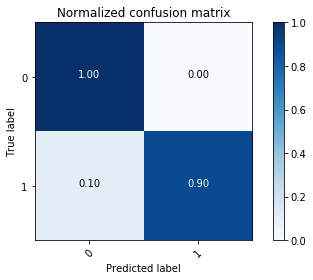

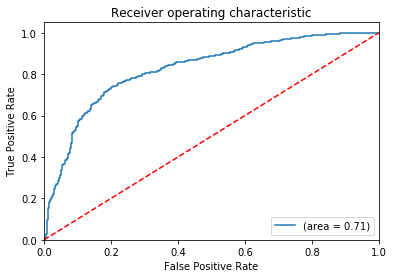

In [83]:
[X_train, X_test, y_train, y_test] = get_train_test_data(over_sampling = False, under_sampling = True, rfe_enabled = False, normalized_enabled = True)


from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#print(X.shape)

clf = LogisticRegressionCV(cv=5, random_state=0,
                           multi_class='multinomial' ).fit(X_train, y_train)

print_performance(clf,X_train, X_test, y_train, y_test)
plot_roc (clf, 'logistic', X_test, y_test)

## Random Forest is the best one here

(5054, 70)
Testing Performance
[[365 143]
 [ 80 423]]
             precision    recall  f1-score   support

          0       0.82      0.72      0.77       508
          1       0.75      0.84      0.79       503

avg / total       0.78      0.78      0.78      1011

Normalized confusion matrix
[[ 0.719  0.281]
 [ 0.159  0.841]]
Training Performance
[[1457  562]
 [ 349 1675]]
             precision    recall  f1-score   support

          0       0.81      0.72      0.76      2019
          1       0.75      0.83      0.79      2024

avg / total       0.78      0.77      0.77      4043



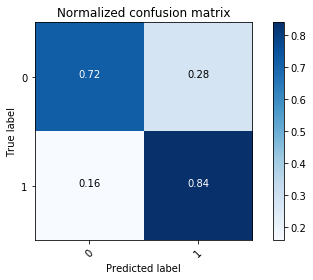

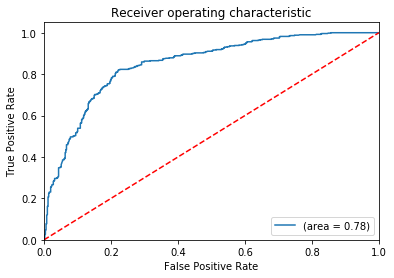

In [64]:
[X_train, X_test, y_train, y_test] = get_train_test_data(over_sampling = False, under_sampling = True, rfe_enabled = False, normalized_enabled = True)


from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

print_performance(clf,X_train, X_test, y_train, y_test)
plot_roc (clf,'random_forest', X_test, y_test)

## SVM 

(5054, 70)
Testing Performance
[[401 107]
 [102 401]]
             precision    recall  f1-score   support

          0       0.80      0.79      0.79       508
          1       0.79      0.80      0.79       503

avg / total       0.79      0.79      0.79      1011

Normalized confusion matrix
[[ 0.789  0.211]
 [ 0.203  0.797]]
Training Performance
[[1622  397]
 [ 380 1644]]
             precision    recall  f1-score   support

          0       0.81      0.80      0.81      2019
          1       0.81      0.81      0.81      2024

avg / total       0.81      0.81      0.81      4043



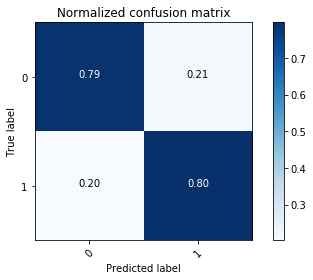

In [73]:
[X_train, X_test, y_train, y_test] = get_train_test_data(over_sampling = False, under_sampling = True, rfe_enabled = False, normalized_enabled = True)


from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

print_performance(clf,X_train, X_test, y_train, y_test)


In [ ]:
X.head()

## Doing some Cool Statistics

In [ ]:
df = pd.read_csv('../sbdc_data_merged.csv')
df.columns
df['Effectiveness'] = (df['Impact: Revenue Increase'] / df['Company\'s Gross Revenue, $'])/df['Total Counseling Time, hrs']
df = df.sort_values(by='Effectiveness',ascending=False)
df.head(100)

In [ ]:
df = df[df['Impact: Started Business'] == 'Not applicable: Already in Business']


pd.crosstab(df['County'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each County')
plt.xlabel('County')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_county')

table=pd.crosstab(df['County'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs County')
plt.xlabel('County')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_county_stack')



pd.crosstab(df['NAICS code'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each NAICS code')
plt.xlabel('NAICS code')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_naics')

table=pd.crosstab(df['NAICS code'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs NAICS code')
plt.xlabel('NAICS code')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_naics_stack')



pd.crosstab(df['Impact: Started Business'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Impact: Started Business')
plt.xlabel('Impact: Started Business')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_impact_start_business')

table=pd.crosstab(df['Impact: Started Business'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Impact: Started Business')
plt.xlabel('Impact: Started Business')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_impact_start_business_stack')



pd.crosstab(df['Initial Services Sought at First Visit'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Initial Services Sought at First Visit')
plt.xlabel('Initial Services Sought at First Visit')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_init_service')

table=pd.crosstab(df['Initial Services Sought at First Visit'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Initial Services Sought at First Visit')
plt.xlabel('Initial Services Sought at First Visit')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_init_service')



pd.crosstab(df['Attended Group Training?'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Attended Group Training?')
plt.xlabel('Attended Group Training?')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_group')

table=pd.crosstab(df['Attended Group Training?'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Attended Group Training?')
plt.xlabel('Attended Group Training?')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_group')



pd.crosstab(df['Ownership Gender'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Ownership Gender')
plt.xlabel('Ownership Gender')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_gender')

table=pd.crosstab(df['Ownership Gender'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Ownership Gender')
plt.xlabel('Ownership Gender')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_gender')



pd.crosstab(df['Owner\'s Hispanic Origin'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Owner\'s Hispanic Origin')
plt.xlabel('Owner\'s Hispanic Origin')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_hispanic')

table=pd.crosstab(df['Owner\'s Hispanic Origin'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Owner\'s Hispanic Origin')
plt.xlabel('Owner\'s Hispanic Origin')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_hispanic')



pd.crosstab(df['Owner\'s Race'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Owner\'s Race')
plt.xlabel('Owner\'s Race')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_race')

table=pd.crosstab(df['Owner\'s Race'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Owner\'s Race')
plt.xlabel('Owner\'s Race')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_race')



pd.crosstab(df['Business Status'],df['y']).plot(kind='bar')
plt.title('Frequency of Revenue Increase for Each Business Status')
plt.xlabel('Business Status')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('revenue_fre_business_status')

table=pd.crosstab(df['Business Status'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Revenue Increase vs Business Status')
plt.xlabel('Business Status')
plt.ylabel('Frequency of Revenue Increase')
plt.savefig('rev_vs_business_status')

